In [55]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from glob import glob
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
import seaborn as sns
from sklearn.impute import SimpleImputer
!pip install category_encoders
from category_encoders import OneHotEncoder

In [63]:
def wrangle(filepath): # using the wrangle function to automate cleaning since we have five datasets.
  df=pd.read_csv(filepath)

  # Data cleaning

  # Dropping columns that add no value to our model.
  df.drop(columns=['Unnamed: 0', 'operation', 'price','currency','price_aprox_local_currency',
                   'surface_total_in_m2','price_usd_per_m2','floor','rooms','expenses',
                   'properati_url','price_per_m2'], inplace=True)

  # Drop "NAN" values
  df.dropna(inplace=True)

   # Creating a new column for our neighborhood.
  df['neighborhood']=df['place_with_parent_names'].str.split('|', expand=True)[2]
  df.drop(columns='place_with_parent_names', inplace=True)

  #selecting apartments for our model
  mask_type=df['property_type']=='apartment'
  df=df[mask_type]

  # creating lat and lon columns. They should not be togethet
  df[['lat','lon']]=df['lat-lon'].str.split(',',expand=True).astype('float64')
  df.drop(columns='lat-lon', inplace=True)

  # Detecting and removing outliers.
  q1=df['surface_covered_in_m2'].quantile(0.25)
  q3=df['surface_covered_in_m2'].quantile(0.75)
  iqr=q3-q1
  upper_limit=q3+(iqr*1.5)
  lower_limit=q1-(iqr*1.5)
  df.loc[df['surface_covered_in_m2']>upper_limit,'surface_covered_in_m2']=upper_limit
  df.loc[df['surface_covered_in_m2']<lower_limit,'surface_covered_in_m2']=lower_limit

  q1=df['price_aprox_usd'].quantile(0.25)
  q3=df['price_aprox_usd'].quantile(0.75)
  iqr=q3-q1
  upper_limit=q3+(iqr*1.5)
  lower_limit=q1-(iqr*1.5)
  df.loc[df['price_aprox_usd']>upper_limit,'price_aprox_usd']=upper_limit
  df.loc[df['price_aprox_usd']<lower_limit,'price_aprox_usd']=lower_limit

  # Removing logically impossible values for surface covered
  df=df[df['surface_covered_in_m2']>=10]





  return df

In [56]:
df=pd.read_csv('/content/drive/MyDrive/mexico-city-real-estate-1.csv')
print('shape:',df.shape)
df.head()

shape: (4628, 17)


,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,1,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,2,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,4,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,5,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


In [64]:
df=wrangle('/content/drive/MyDrive/mexico-city-real-estate-1.csv')
print('shape:',df.shape)
df.head()


shape: (2626, 6)


,property_type,price_aprox_usd,surface_covered_in_m2,neighborhood,lat,lon
0,apartment,289775.66000,54.0,Distrito Federal,23.634501,-102.552788
2,apartment,48822.82000,100.0,Distrito Federal,19.279771,-99.234597
3,apartment,337720.36000,135.0,Distrito Federal,23.634501,-102.552788
4,apartment,448925.18125,202.0,Quintana Roo,21.190264,-86.819838
5,apartment,232663.51000,87.0,Distrito Federal,19.432657,-99.177444


In [ ]:
import plotly.express as px
import plotly.io as pio
from IPython.display import Image

# Create the boxplot
fig = px.box(data_frame=df, y='price_aprox_usd')

# Save it as a PNG image (requires 'kaleido')
pio.write_image(fig, 'boxplot_price_aprox_usd.png')

# Display the saved image (will work on GitHub)
Image('boxplot_price_aprox_usd.png')


In [58]:
fig=px.histogram(data_frame=df, x='price_aprox_usd')
fig.show()
fig2=px.histogram(data_frame=df, x='surface_covered_in_m2')
fig2.show()

In [59]:
# Removing outliers using the IQR method
q1=df['price_aprox_usd'].quantile(0.25)
q3=df['price_aprox_usd'].quantile(0.75)
iqr=q3-q1
upper_limit=q3+(iqr*1.5)
lower_limit=q1-(iqr*1.5)
df.loc[df['price_aprox_usd']>upper_limit,'price_aprox_usd']=upper_limit
df.loc[df['price_aprox_usd']<lower_limit,'price_aprox_usd']=lower_limit

In [60]:
q1=df['surface_covered_in_m2'].quantile(0.25)
q3=df['surface_covered_in_m2'].quantile(0.75)
iqr=q3-q1
upper_limit=q3+(iqr*1.5)
lower_limit=q1-(iqr*1.5)
df.loc[df['surface_covered_in_m2']>upper_limit,'surface_covered_in_m2']=upper_limit
df.loc[df['surface_covered_in_m2']<lower_limit,'surface_covered_in_m2']=lower_limit

In [61]:
fig=px.box(data_frame=df, y='price_aprox_usd')
fig.show()
fig2=px.box(data_frame=df, y='surface_covered_in_m2')
fig2.show()
# No outliers are present in our data.

In [62]:
fig=px.histogram(data_frame=df, x='price_aprox_usd')
fig.show()
fig2=px.histogram(data_frame=df, x='surface_covered_in_m2')
fig2.show()

In [65]:
df['surface_covered_in_m2'].describe() #However, surface area shows the minimum sq m2 is 0.
# Outlier detection usually focuses on statistical extremes, not logical impossibilities.

,surface_covered_in_m2
count,2626.000000
mean,98.378522
std,48.241668
min,10.000000
25%,63.000000
50%,80.000000
75%,120.000000
max,202.000000


In [66]:
df=df[df['surface_covered_in_m2']>=10] # since we are dealing with housing, a reasonable living space would be 10 m2
df['surface_covered_in_m2'].describe()

,surface_covered_in_m2
count,2626.000000
mean,98.378522
std,48.241668
min,10.000000
25%,63.000000
50%,80.000000
75%,120.000000
max,202.000000


In [67]:
df['price_aprox_usd'].describe()
# Data is consistent and lacks outliers

,price_aprox_usd
count,2626.000000
mean,153986.762561
std,132461.293036
min,7823.940000
25%,52118.452500
50%,100326.950000
75%,210614.215000
max,448925.181250


In [68]:
# Housing in mexico contains five datasets.
# Already cleaned one.
# Wrangle function created to automate data cleaning
# Import all the remaining data sets using glob
files=glob("/content/drive/MyDrive/mexico-city-real-estate-*.csv")
files

['/content/drive/MyDrive/mexico-city-real-estate-2.csv',
 '/content/drive/MyDrive/mexico-city-real-estate-3.csv',
 '/content/drive/MyDrive/mexico-city-real-estate-1.csv',
 '/content/drive/MyDrive/mexico-city-real-estate-4.csv',
 '/content/drive/MyDrive/mexico-city-real-estate-5.csv']

In [69]:
frames=[]
for file in files:
  df=wrangle(file)
  frames.append(df)
df=pd.concat(frames, ignore_index=True) # imported and cleaned all files
print("shape:", df.shape) # initially we had about 2000 rows and 6 columns, now we have about 12000 rows and 6 columns
df.head()

shape: (12973, 6)


,property_type,price_aprox_usd,surface_covered_in_m2,neighborhood,lat,lon
0,apartment,63223.78,88.0,Distrito Federal,19.516777,-99.160149
1,apartment,25289.51,48.0,Distrito Federal,19.466724,-99.131614
2,apartment,240211.43,126.0,Distrito Federal,19.332280,-99.243934
3,apartment,200682.34,171.0,Quintana Roo,21.110577,-86.853786
4,apartment,91147.61,100.0,Distrito Federal,19.393650,-99.147690


In [70]:
# Data exploration
average_cost=df.groupby('neighborhood')['price_aprox_usd'].mean().reset_index()
average_cost.round(2)
fig=px.bar(average_cost,x='neighborhood', y='price_aprox_usd', title='Average Cost of Housing by Neighborhood')
fig.update_layout(
    font_family='Arial Black',
    font_color='Dark blue',
    font_weight='bold',
    font_size=12
)
fig.show()

In [71]:
average_cost=df.groupby('neighborhood')['surface_covered_in_m2'].mean().reset_index()
average_cost.round(2)
fig=px.bar(average_cost,x='neighborhood', y='surface_covered_in_m2', title='Average Surface Covered by Neighborhood')
fig.update_layout(
    font_family='Arial Black',
    font_color='Dark blue',
    font_weight='bold',
    font_size=12
)
fig.show()

In [72]:
# Machine learning
features=['surface_covered_in_m2']
X_train=df[features]
target='price_aprox_usd'
y_train=df['price_aprox_usd']
y_mean=y_train.mean().round(2)
y_predict_baseline=[y_mean]*len(y_train)
y_predict_baseline[:5]

[np.float64(154192.78),
 np.float64(154192.78),
 np.float64(154192.78),
 np.float64(154192.78),
 np.float64(154192.78)]

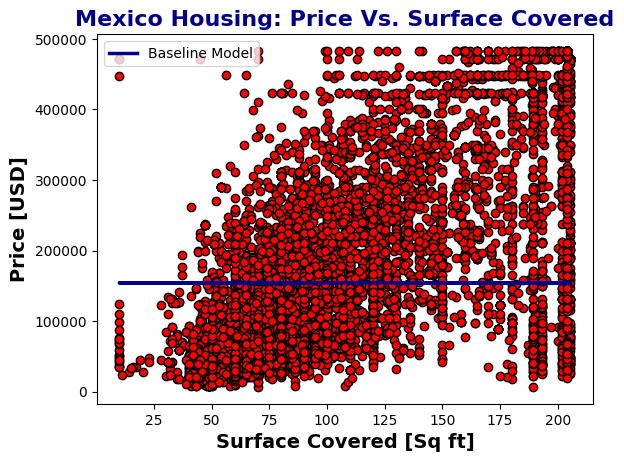

In [73]:
plt.scatter(X_train, y_train,color='red',alpha=1, edgecolor='k')
plt.plot(X_train, y_predict_baseline, color='darkblue',linewidth=2.5, label="Baseline Model")
plt.title("Mexico Housing: Price Vs. Surface Covered",fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Surface Covered [Sq ft]",fontsize=14, fontweight='bold', color='black')
plt.ylabel("Price [USD]",fontsize=14, fontweight='bold', color='black')
plt.legend()
plt.show()


In [74]:
# Mean absolute error baseline
mae_baseline=round(mean_absolute_error(y_train, y_predict_baseline),2)
mae_baseline
# On average, the baseline model is off by ~$107,161 from the true price.

107161.33

In [75]:
model=LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [76]:
y_predict_training=model.predict(X_train)
mae_training=round(mean_absolute_error(y_train, y_predict_training),2)
mae_training

#On average, the trained model is off by ~$63,240.
#This is better than the baseline — it shows your model learned useful patterns from the data.

63239.83

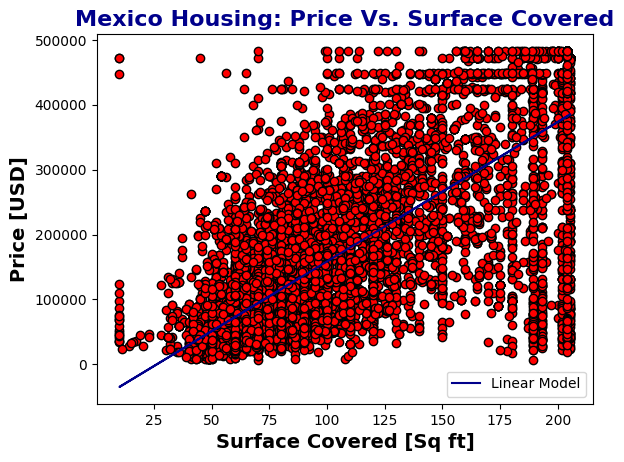

In [77]:
plt.scatter(X_train, y_train, color='red', edgecolor='k',alpha=1)
plt.plot(X_train, y_predict_training, color='darkblue', label="Linear Model")
plt.title("Mexico Housing: Price Vs. Surface Covered",fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Surface Covered [Sq ft]",fontsize=14, fontweight='bold', color='black')
plt.ylabel("Price [USD]",fontsize=14, fontweight='bold', color='black')
plt.legend()
plt.show()

In [ ]:
# The model shows a positive correlation between surface covered and price. An increase in surface covered results in an increase in price.
#